In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
# import data from CA, CT, TX, FL, NY, NJ 
ca = pd.read_csv('data/ca_ev_registrations_public.csv')
# nj = pd.read_csv('data/nj_ev_registrations_public.csv')
# ny = pd.read_csv('data/ny_ev_registrations_public.csv')
# tx = pd.read_csv('data/tx_ev_registrations_public.csv')
# fl = pd.read_csv('data/fl_ev_registrations_public.csv')
# ct = pd.read_csv('data/ct_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Create Data frame with years and amount of registered vehicles in that year
ca_years = pd.DataFrame(ca['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])
ca_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year                 11 non-null     object
 1   Registered Vehicles  11 non-null     object
dtypes: object(2)
memory usage: 304.0+ bytes


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11 entries, 2020-01-01 to 2010-01-01
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Registered Vehicles  11 non-null     object
dtypes: object(1)
memory usage: 176.0+ bytes


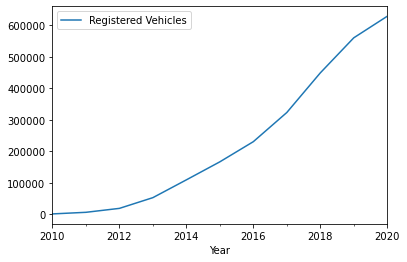

In [4]:
# As we can see, data is not stationary. 
ca_df = pd.DataFrame(ca_years['Registered Vehicles'])
ca_df = ca_df.set_axis(pd.to_datetime(ca_years['Year']))
ca_df.plot()
ca_df.info()
ca_df = ca_df.sort_values(by=['Registered Vehicles'], ascending = True)

In [5]:
ca_df = ca_df.astype(float)
ca_df

,Registered Vehicles
Year,
2010-01-01,754.0
2011-01-01,5857.0
2012-01-01,18356.0
2013-01-01,52427.0
2014-01-01,108939.0
2015-01-01,166168.0
2016-01-01,230171.0
2017-01-01,322762.0
2018-01-01,448567.0


,Registered Vehicles
Year,
2010-01-03,5857.0
2010-01-10,5857.0
2010-01-17,5857.0
2010-01-24,5857.0
2010-01-31,5857.0


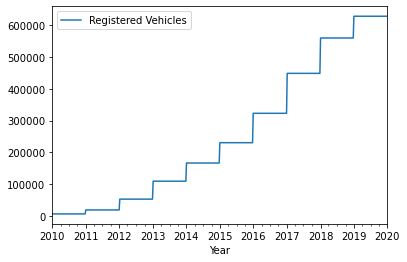

In [6]:
ca_df = ca_df.resample('W').bfill()
ca_df.plot()
ca_df.head()

In [16]:
catest = adfuller(ca_df)
display(catest)
# nan pvalue when bfill 

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: invalid value encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


(nan,
 nan,
 0,
 522,
 {'1%': -3.4429395567097445,
  '5%': -2.8670927932098063,
  '10%': -2.569727435298953},
 nan)

# Modeling

In [17]:
catrain = ca_df['2010':'2018']
catest = ca_df['2019':'2020']
combined = ca_df

catest

,Registered Vehicles
Year,
2019-01-06,628473.0
2019-01-13,628473.0
2019-01-20,628473.0
2019-01-27,628473.0
2019-02-03,628473.0
2019-02-10,628473.0
2019-02-17,628473.0
2019-02-24,628473.0
2019-03-03,628473.0


In [18]:
auto_modelca = pm.auto_arima(catrain, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_modelca.summary())

# (1,0,1), (0,0,0) , [0]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13131.022, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12792.785, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10022.355, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10024.222, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10024.358, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12716.692, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10026.218, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10026.356, Time=0.17 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.392 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  470
Model:               SARIMAX(1, 0, 1)   Log Likelihood          

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0036      0.006    167.941      0.000       0.992       1.015
ma.L1         -0.0137      1.588     -0.009      0.993      -3.126       3.099
sigma2      1.035e+08   1.58e-08   6.53e+15      0.000    1.03e+08    1.03e+08


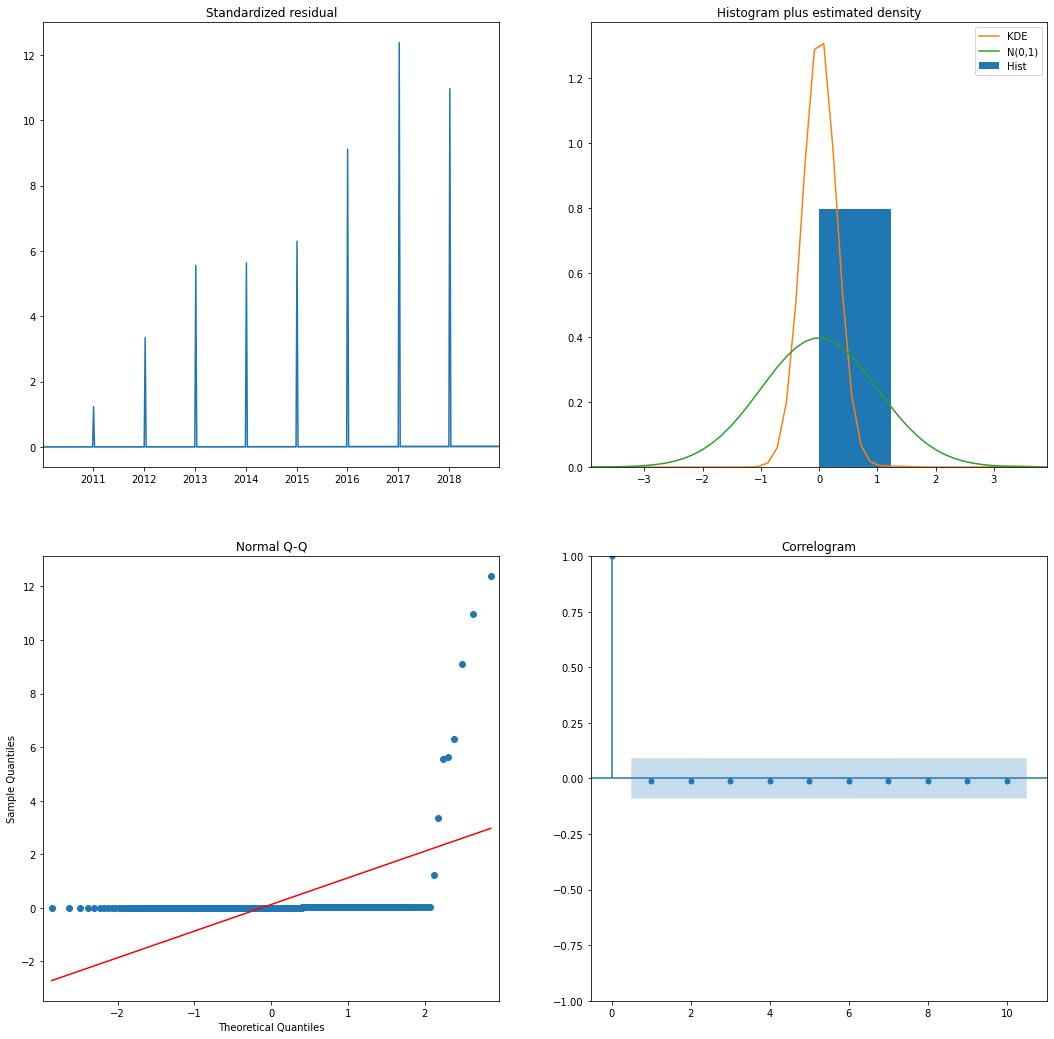

In [19]:
ARIMA_MODELCA = sm.tsa.statespace.sarimax.SARIMAX(catrain, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


outputca = ARIMA_MODELCA.fit()

print(outputca.summary().tables[1])
auto_modelca.plot_diagnostics(figsize=(18,18))
plt.show()

In [20]:
predca = outputca.get_prediction(start=pd.to_datetime('2019-01-06'), end=pd.to_datetime('2020-01-05'), dynamic=False)
pred_confca = predca.conf_int()
pred_confca

,lower Registered Vehicles,upper Registered Vehicles
2019-01-06,542079.152654,581949.401114
2019-01-13,535988.554286,592089.180627
2019-01-20,531733.575789,600407.926969
2019-01-27,528435.099659,607784.810191
2019-02-03,525749.319902,614563.689025
2019-02-10,523499.299299,620921.553614
2019-02-17,521579.789116,626963.705810
2019-02-24,519922.193775,632758.794499
2019-03-03,518478.880769,638354.505687
2019-03-10,517215.192469,643785.550698


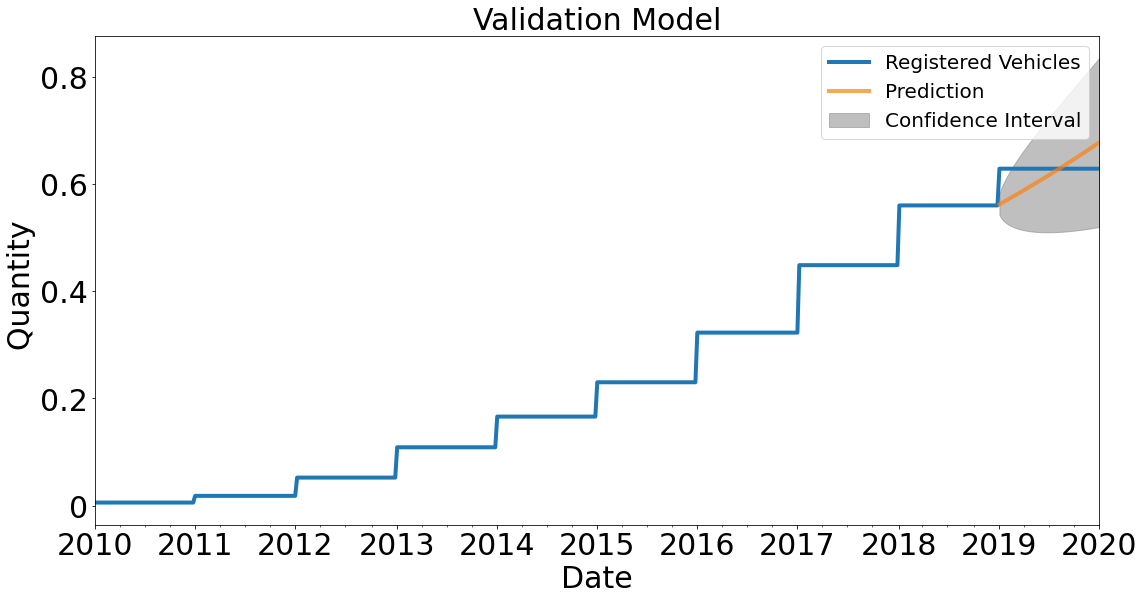

In [21]:


rcParams['figure.figsize'] = 18, 9
ax = ca_df.plot(label='observed', linewidth = 4)

predca.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.7, linewidth = 4)


ax.fill_between(pred_confca.index,
                pred_confca.iloc[:, 0],
                pred_confca.iloc[:, 1], color='grey', alpha=0.5,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity ',fontsize=30)
plt.yticks(fontsize=30)
#Changing the y scale to ($) Millions
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [13]:

# ca_df.head()

In [14]:
# Differencing to be stationary 
# ca_diff = ca_df.diff().dropna()
# ca_diff.plot()

In [15]:
cadifftest = adfuller(ca_diff)
display(cadifftest)
# Pvalue -  0.9754235581948372

NameError: name 'ca_diff' is not defined

In [ ]:

# plot_acf(ca_diff, ax=ax, lags = 3)

#### Lets take the necessary data from each of the data frames - specifically date, and convert them into a usable format as they are currently 'objects' and need them to be in datetime format for analyses